In [1]:
import csv
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp as lse
plt.style.use('ggplot')
%matplotlib inline

In [2]:
BATCH_SIZE = 2**21

def compute_residuals(params, N, D, L):
    E, A, alpha, B, beta = params
    return E + A/(N**alpha) + B/(D**beta) - L

def compute_loss(params, N, D):
    E, A, alpha, B, beta = params
    return E + A/(N**alpha) + B/(D**beta)

param_key = {
    "70M": 70_426_624,
    "160M": 162_322_944,
    "410M": 405_334_016,
    "1-4B": 1_414_647_808,
    "2-8B": 2_775_208_960,
    "6-9B": 6_857_302_016,
    "12B": 11_846_072_320
}

def column_rename(name: str):
    for x in [*param_key.keys(), "Step"]:
        if x in name:
            return x
    
    raise ValueError 

In [3]:
def scaling_scatter(N, N_labels, D, L, params=None):
    if params is not None:
        # if params, fit excess risk instead of loss
        entropy = params[0]
        L = L - entropy
        params[0] = 0
        ylabel = "Excess risk"
    else:
        ylabel = "Loss"
        
    plt.figure(figsize=(10, 6))

    unique_labels = np.unique(N_labels)
    for label in unique_labels:
        idx = np.where(N_labels == label)
        plt.scatter(D[idx], L[idx], label=label)
        
    if params is not None:
        D_values = np.logspace(np.log10(min(D)), np.log10(max(D)), 100)  # Create an array of D values to plot
        for label in unique_labels:
            num_params = param_key[label]
            losses = compute_loss(params, num_params, D_values)
            plt.plot(D_values, losses, label=None, linestyle='--')
        
        # efficient frontier
        E, A, alpha, B, beta = params
        N_opt = np.power((alpha*A)/(beta*B) * np.power(D_values, beta), 1/alpha)
        efficient_loss = compute_loss(params, N_opt, D_values)
        plt.plot(D_values, efficient_loss, label='Efficient frontier', linestyle='dotted')
        
        E, A, alpha, B, beta = tuple(r'{' + f'{x:.2f}' r'}' for x in params)
        plt.text(
            D_values[0], min(L), 
            f'$L = {entropy:.2f} + {A}/N^{alpha} + {B}/D^{beta}$',
            verticalalignment='bottom', horizontalalignment='left'
        )
            

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Tokens (D)')
    plt.ylabel(ylabel)
    plt.legend(title='N_label')
    plt.title('Scatter Plot of Loss vs Tokens')
    plt.savefig("pile-scaling-0.3.png")
    plt.show()

In [4]:
df = pd.read_csv("pile-scaling-0.3.csv")

cols_to_drop = [col for col in df.columns if 'MIN' in col or 'MAX' in col]
df.drop(columns=cols_to_drop, inplace=True)

df = df.rename(columns=column_rename)

df = df.groupby(df.columns, axis=1).first()

melted_df = df.melt(id_vars=['Step'], value_vars=['1-4B', '160M', '410M', '70M'], 
                    var_name='Column_name', value_name='Value')
filtered_df = melted_df.dropna(subset=['Value'])

# Convert to triples
triples = list(filtered_df.itertuples(index=False, name=None))

N = np.array([param_key[x[1]] for x in triples])
N_labels = np.array([x[1] for x in triples])
D = np.array([x[0]*BATCH_SIZE for x in triples])
L = np.array([x[2] for x in triples])

print(triples)

[(4096.0, '1-4B', 2.256822109222412), (8192.0, '1-4B', 2.110085248947144), (12288.0, '1-4B', 2.045180320739746), (1536.0, '160M', 2.7899272441864014), (2048.0, '160M', 2.693813800811768), (3072.0, '160M', 2.58536148071289), (4096.0, '160M', 2.521445035934448), (2048.0, '410M', 2.639939546585083), (3072.0, '410M', 2.496314764022827), (4096.0, '410M', 2.41260290145874), (6144.0, '410M', 2.315460205078125), (1024.0, '70M', 3.1299679279327397), (1536.0, '70M', 2.9992475509643555), (2048.0, '70M', 2.917292594909668), (3072.0, '70M', 2.8291783332824707)]


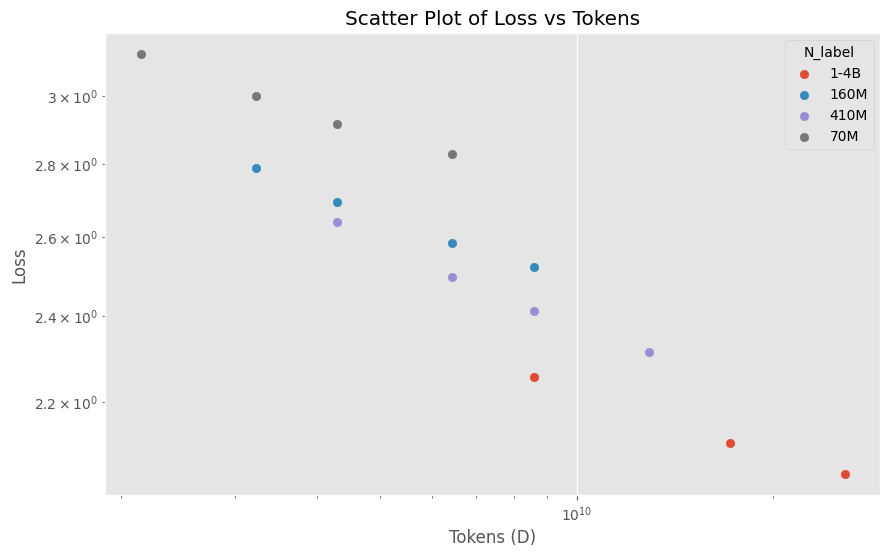

In [5]:
scaling_scatter(N, N_labels, D, L)

In [6]:
import numpy as np
from scipy.optimize import least_squares

initial_guess = [1.0, 400, 0.5, 400, 0.5]

result = least_squares(compute_residuals, initial_guess, args=(N, D, L))

params = result.x
E_opt, A_opt, alpha_opt, B_opt, beta_opt = params
cost = result.cost

print(f"Optimized parameters: E = {E_opt}, A = {A_opt}, alpha = {alpha_opt}, B = {B_opt}, beta = {beta_opt}")
print(f"Cost: {cost}")

Optimized parameters: E = 0.8050473207999971, A = 3724.438173586794, alpha = 0.4855443635639823, B = 96.96000616194083, beta = 0.18691371714905564
Cost: 0.003908275585120159


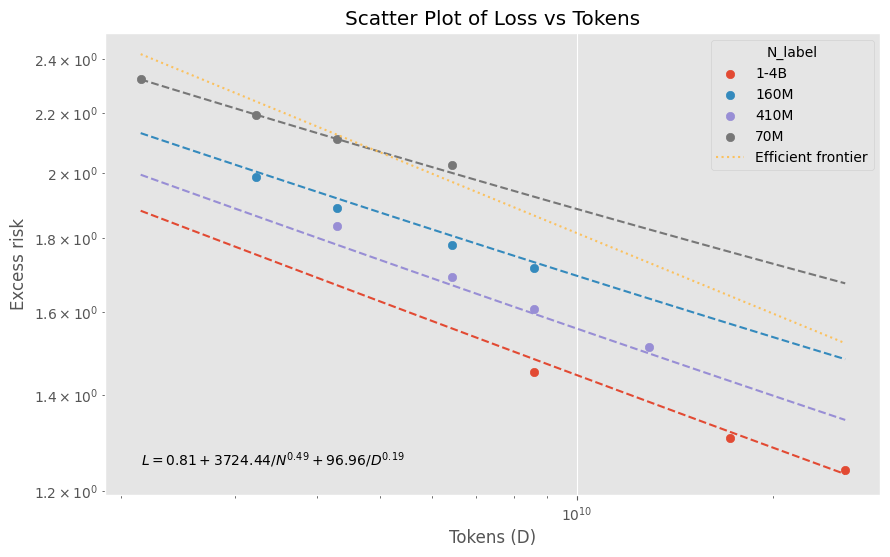

In [7]:
scaling_scatter(N, N_labels, D, L, params=params)